In [6]:
# ====================================
#               IMPORTS
# ====================================

# GUI Libraries
import tkinter as tk
from tkinter import ttk, filedialog
#import pyautogui

# Plotting and Visualization
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

# KMeans and Data Manipulation
import numpy as np
from sklearn.cluster import KMeans

# Ray-Tracing Simulation
import sionna
from sionna.rt import load_scene, Transmitter, Receiver, RIS, PlanarArray, Camera

# Utility Libraries
#import threading
#import random
import json
import ast
from typing import Dict, List, Tuple
from collections import defaultdict

# Matplotlib Backend Setup
matplotlib.use('TkAgg')  # Use TkAgg backend for embedding plots in Tkinter

# TensorFlow Setup
import tensorflow as tf
tf.get_logger().setLevel('ERROR')  # Suppress TensorFlow warnings
gpu_num = 0  # Specify the GPU to use; leave as "" to use the CPU
# Uncomment to configure GPU/CPU explicitly:
# os.environ["CUDA_VISIBLE_DEVICES"] = f"{gpu_num}"
# os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

# ====================================
#          EXTERNAL FUNCTIONS
# ====================================

# Capture screenshot of the GUI after it's displayed
def take_screenshot():
    root.update()  # Ensure the window is fully loaded
    x = root.winfo_rootx()
    y = root.winfo_rooty()
    width = root.winfo_width()
    height = root.winfo_height()
    screenshot = pyautogui.screenshot(region=(x, y, width, height))
    screenshot.save("gui_screenshot.png")
    root.destroy()

# Helper function to compute dB
def to_db(x):
    return 10*tf.math.log(x)/tf.math.log(10.)

def calculate_cdf(tensor):
    """
    Calculate the CDF of power levels for a single 2D tensor.

    Parameters:
        tensor (tf.Tensor): A 2D TensorFlow tensor representing the coverage map (values in decimal).

    Returns:
        tuple: (sorted_values_db, cdf)
            - sorted_values_db (np.ndarray): Sorted power levels in dB (NumPy array).
            - cdf (np.ndarray): Corresponding CDF values (NumPy array).
    """
    # Flatten the tensor and filter out zero or negative values
    tensor_flat = tf.reshape(tensor, [-1])
    non_zero_values = tf.boolean_mask(tensor_flat, tensor_flat > 0.0)

    if tf.size(non_zero_values) == 0:  # Handle empty or zero-only tensors
        return np.array([]), np.array([])

    # Sort values and convert to dB
    sorted_values = tf.sort(non_zero_values)
    sorted_values_db = 10 * tf.math.log(sorted_values) / tf.math.log(10.0)

    # Compute the CDF
    num_values = tf.cast(tf.size(sorted_values), tf.float32)
    cdf = tf.range(1, num_values + 1, dtype=tf.float32) / num_values

    return sorted_values_db.numpy(), cdf.numpy()

def plot_multiple_cdfs(cdfs, labels):
    """
    Plot multiple CDFs on the same figure.

    Parameters:
        cdfs (list of tuples): A list of tuples, where each tuple contains (sorted_values_db, cdf).
        labels (list of str): A list of labels corresponding to each CDF.

    Returns:
        None: The function plots the combined CDFs.
    """
    if len(cdfs) != len(labels):
        raise ValueError("The number of CDFs must match the number of labels.")

    plt.figure()
    
    # Plot each CDF
    marker_count = 0
    marker_list = ['o','v','^','<','>','*','x']
    for (sorted_values_db, cdf), label in zip(cdfs, labels):
        if "Distance" in label:
            plt.plot(sorted_values_db, cdf, label=label, marker=marker_list[marker_count], markevery=100, markersize=7, linestyle='--')
        else:
            plt.plot(sorted_values_db, cdf, label=label, marker=marker_list[marker_count], markevery=100, markersize=7)
        marker_count = marker_count + 1

    plt.xlabel('Power level (dB)')
    plt.ylabel('CDF (%)')
    #plt.title('CDF of Power Levels')
    plt.grid(True)
    plt.legend()
    plt.show()

def calculate_coverage_ratio(tensor, threshold_db):
    """
    Calculate the coverage ratio of a 2D tensor based on a power threshold.

    Parameters:
        tensor (tf.Tensor): A 2D TensorFlow tensor representing the coverage map (values in decimal).
        threshold_db (float): Power threshold in dB.

    Returns:
        float: The coverage ratio.
    """
    # Convert threshold from dB to decimal
    threshold_decimal = 10 ** (threshold_db / 10)

    # Mask non-zero values (to exclude walls/obstacles) and check which ones are above the threshold
    non_zero_values = tf.boolean_mask(tensor, tf.not_equal(tensor, 0.0))
    above_threshold_mask = non_zero_values > threshold_decimal

    # Ensure we avoid division by zero (if no non-zero values exist)
    num_non_zero = tf.size(non_zero_values, out_type=tf.float32)
    if num_non_zero == 0:
        return 0.0  # Return 0% coverage if no valid data points

    # Calculate the coverage ratio
    coverage_ratio = tf.reduce_sum(tf.cast(above_threshold_mask, tf.float32)) / num_non_zero * 100

    return float(coverage_ratio)  # Return as a float

def selection(coords, k):
    """
    Perform K-means clustering on a set of coordinates and extract centroids.

    Parameters:
        coords (list or np.ndarray): A list or numpy array of coordinates (in meters), 
                                      where each coordinate is a 3D point [x, y, z].
        k (int): The number of clusters (centroids) to extract from the coordinates.

    Returns:
        np.ndarray: The centroids of the clusters, each of which is a 3D point [x, y, z], 
                    where the z-value is taken from the first input coordinate's z value.
    """
    # Convert coords to a NumPy array if it's not already
    coords = np.array(coords)
    
    # Perform K-means clustering to group coordinates based on x and y
    kmeans = KMeans(n_clusters=k, random_state=0).fit(coords[:, :2])
    
    # Retrieve centroids of the clusters
    centroids = kmeans.cluster_centers_
    
    # Set the z value to that of the first coordinate's z value
    z_value = coords[0, 2]
    centroids = np.hstack([centroids, np.full((k, 1), z_value)])

    return centroids

# ====================================
#                 GUI
# ====================================

class RISGUI:
    def __init__(self, master):
        self.master = master
        master.title("RIS Propagation Optimization")

        # Title label
        self.label_title = tk.Label(master, text="Ray-tracing Based RIS Size, Position and Target Point Optimization", font=("Helvetica", 16, "bold"))
        self.label_title.pack(pady=5)

        # Entry Frame
        self.entry_frame = tk.Frame(master)

        # Scenario selection
        self.scenario_selection_labelframe = tk.LabelFrame(self.entry_frame, text="Scenario selection", padx=5, pady=5)
        self.scenario_options = ["Indoor Office Scenario for OJAP", "Indoor Office Scenario for EuCAP2025", "L-shaped Hallway Scenario for OJAP", "U-shaped Hallway", "T-shaped Hallway"]
        self.scenario_var = tk.StringVar(value="Indoor Office Scenario for OJAP")  # Default to "Indoor Office Scenario for OJAP"
        self.scenario_menu = tk.OptionMenu(self.scenario_selection_labelframe, self.scenario_var, *self.scenario_options)
        self.load_scenario_button = tk.Button(self.scenario_selection_labelframe, text="Load", command=self.load_scenario)
        self.scenario_menu.grid(row=0, column=0, padx=5)
        self.load_scenario_button.grid(row=0, column=1, padx=5)
        self.scenario_selection_labelframe.grid(row=0, column=0, padx=5)

        # Frequency input
        self.frequency_labelframe = tk.LabelFrame(self.entry_frame, text="Scene frequency (Hz)", padx=6, pady=6)
        self.entry_frequency = tk.Entry(self.frequency_labelframe, width=7)
        self.entry_frequency.pack(pady=5)        
        self.frequency_labelframe.grid(row=0, column=1, padx=5)

        # TX position input
        self.tx_pos_labelframe = tk.LabelFrame(self.entry_frame, text="TX position (x, y, z)", padx=11, pady=11)
        self.entry_tx_x = tk.Entry(self.tx_pos_labelframe, width=5)
        self.entry_tx_x.grid(row=0, column=0, padx=5)
        self.entry_tx_y = tk.Entry(self.tx_pos_labelframe, width=5)
        self.entry_tx_y.grid(row=0, column=1, padx=5)
        self.entry_tx_z = tk.Entry(self.tx_pos_labelframe, width=5)
        self.entry_tx_z.grid(row=0, column=2, padx=5)
        self.tx_pos_labelframe.grid(row=0, column=2, padx=5)

        # Power threshold input
        self.min_power_threshold_labelframe = tk.LabelFrame(self.entry_frame, text="Minimum power \n threshold (dB)", padx=6, pady=6)
        self.entry_threshold = tk.Entry(self.min_power_threshold_labelframe, width=5)
        self.entry_threshold.pack(pady=5)              
        self.min_power_threshold_labelframe.grid(row=0, column=3, padx=5)

        # Coverage map cell size input
        self.cov_map_cell_size_labelframe = tk.LabelFrame(self.entry_frame, text="Coverage map\ncell size (m)", padx=6, pady=6)
        self.cov_map_cell_size = tk.Entry(self.cov_map_cell_size_labelframe, width=5)
        self.cov_map_cell_size.pack(pady=5)              
        self.cov_map_cell_size_labelframe.grid(row=0, column=4, padx=5)          

        self.entry_frame.pack(pady=5)

        # Buttons Frame
        self.buttons_frame = tk.Frame(master)
        
        # Preset button
        self.button_preset = tk.Button(self.buttons_frame, text="Preset parameters", command=self.set_preset_values, padx=20)
        self.button_preset.grid(row=0, column=0, padx=5)
        
        # Clear button
        self.button_clear = tk.Button(self.buttons_frame, text="Clear parameters", command=self.clear_values, padx=20)
        self.button_clear.grid(row=0, column=1, padx=5)
        
        # Preview button
        self.button_preview = tk.Button(self.buttons_frame, text="Preview scenario", command=self.preview_scenario, padx=20)
        self.button_preview.grid(row=0, column=2, padx=5)
        
        # Compute TX-Only Coverage button
        self.button_TX_coverage = tk.Button(self.buttons_frame, text="Compute TX-only coverage map", command=self.compute_tx_coverage, padx=20)
        self.button_TX_coverage.grid(row=0, column=3, padx=5)
        
        self.buttons_frame.pack(pady=5)

        # Phase Profile selection
        self.phase_profile_selection_frame = tk.Frame(master)
        self.label_pp = tk.Label(self.phase_profile_selection_frame, text="Choose phase profile approach:")
        self.pp_var = tk.StringVar(value="Gradient-based")
        self.pp_options = ["Gradient-based", "Distance-based"]
        self.pp_menu = tk.OptionMenu(self.phase_profile_selection_frame, self.pp_var, *self.pp_options)
        
        self.label_pp.grid(row=0, column=0, padx=5)
        self.pp_menu.grid(row=0, column=1, padx=5)
        self.phase_profile_selection_frame.pack(pady=5)

        # Manual and optimization frame
        self.manual_and_optimization_frame = tk.Frame(master)

        # Manual trials (left-side)
        self.manual_trials_labelframe = tk.LabelFrame(self.manual_and_optimization_frame, text="Manual trials", padx=6, pady=6)
        
        # Enter Number of Target Points of RIS
        self.num_target_labelframe = tk.LabelFrame(self.manual_trials_labelframe, text="Number of target points", padx=6, pady=6)
        self.entry_num_target = tk.Entry(self.num_target_labelframe, width=5)
        self.entry_num_target.pack()
        self.num_target_labelframe.pack(pady=5)   

        # Clustering algorithm button
        self.button_clustering = tk.Button(self.manual_trials_labelframe, text="Find the target point(s) via clustering algorithm",
                                           command=self.clustering_algo)
        self.button_clustering.pack(pady=5)

        # RIS target point(s) choice (Algorithm or manual)
        self.ris_target_points_frame = tk.Frame(self.manual_trials_labelframe)
        self.target_point_manual_optimized = tk.StringVar(value="optimized")  # Start with Optimized
        self.target_point_optimized_radio = tk.Radiobutton(self.ris_target_points_frame,
                                                       text="Use the target point(s) found via clustering algorithm",
                                                       variable=self.target_point_manual_optimized, value="optimized",
                                                       command=self.toggle_target_point_input)
        self.target_point_manual_radio = tk.Radiobutton(self.ris_target_points_frame,
                                                    text="Enter the target point(s) manually", variable=self.target_point_manual_optimized,
                                                    value="manual", command=self.toggle_target_point_input)
        self.target_point_optimized_radio.grid(row=0, column=0, padx=5)
        self.target_point_manual_radio.grid(row=1, column=0, padx=5)
        self.ris_target_points_frame.pack(pady=5)        

        self.target_positions_frame = tk.Frame(self.manual_trials_labelframe)
        self.target_positions_frame.pack_forget()  # Initially hidden 

        # Compute potential RIS positions
        self.button_coverage = tk.Button(self.manual_trials_labelframe, text="Compute feasible RIS positions",
                                         command=self.compute_potential_RIS_positions)
        self.button_coverage.pack(pady=5)

        # RIS position input
        self.RIS_position_labelframe = tk.LabelFrame(self.manual_trials_labelframe, text="Enter RIS center position\n(x, y, z)", padx=6, pady=6)
        self.entry_ris_x = tk.Entry(self.RIS_position_labelframe, width=5)
        self.entry_ris_y = tk.Entry(self.RIS_position_labelframe, width=5)
        self.entry_ris_z = tk.Entry(self.RIS_position_labelframe, width=5)
        self.entry_ris_x.grid(row=0, column=0, padx=5)
        self.entry_ris_y.grid(row=0, column=1, padx=5)
        self.entry_ris_z.grid(row=0, column=2, padx=5)
        self.RIS_position_labelframe.pack(pady=5)

        self.ris_size_frame = tk.Frame(self.manual_trials_labelframe)
        self.label_ris_height = tk.Label(self.ris_size_frame, text="RIS height (m):")
        self.label_ris_width = tk.Label(self.ris_size_frame, text="RIS width (m):")
        self.entry_ris_height = tk.Entry(self.ris_size_frame, width=5)
        self.entry_ris_width = tk.Entry(self.ris_size_frame, width=5)

        self.label_ris_height.grid(row=0, column=0, padx=5)
        self.entry_ris_height.grid(row=0, column=1, padx=5)
        self.label_ris_width.grid(row=1, column=0, padx=5)
        self.entry_ris_width.grid(row=1, column=1, padx=5)

        self.ris_size_frame.pack(pady=5)

        # Variable to store the checkbox state (1 for checked, 0 for unchecked)
        self.checkbox_phase_profile_var = tk.IntVar()
        # Create the checkbox
        self.checkbox_phase_profile = tk.Checkbutton(self.manual_trials_labelframe, text="Show phase profile figures",
                                                     variable=self.checkbox_phase_profile_var)
        self.checkbox_phase_profile.pack(pady=5)

        # Compute combined coverage map button
        self.button_combined_coverage = tk.Button(self.manual_trials_labelframe, text="Compute combined coverage map (TX + RIS)",
                                                  command=self.compute_combined_coverage)
        self.button_combined_coverage.pack(pady=5)        
        
        self.manual_trials_labelframe.grid(row=0, column=0, padx=5)

        # Optimization algorithm (right-side)
        self.optimization_labelframe = tk.LabelFrame(self.manual_and_optimization_frame, text="Optimization algorithm", padx=6, pady=6)

        # Number of target point interval
        self.num_target_interval_labelframe = tk.LabelFrame(self.optimization_labelframe,
                                                            text="Number of target point interval \n (N_lower, N_upper, N_step)", padx=6, pady=6)
        self.num_target_interval_labelframe.grid_columnconfigure((0, 1, 2), weight=1)
        self.N_lower = tk.Entry(self.num_target_interval_labelframe, width=5)
        self.N_upper = tk.Entry(self.num_target_interval_labelframe, width=5)
        self.N_step = tk.Entry(self.num_target_interval_labelframe, width=5)
        self.N_lower.grid(row=0, column=0, padx=5)
        self.N_upper.grid(row=0, column=1, padx=5)
        self.N_step.grid(row=0, column=2, padx=5)        
        self.num_target_interval_labelframe.pack(pady=5)

        # RIS height
        self.ris_height_labelframe = tk.LabelFrame(self.optimization_labelframe, text="RIS height (m)", padx=6, pady=6)
        self.ris_height_opt_algo = tk.Entry(self.ris_height_labelframe, width=5)
        self.ris_height_opt_algo.pack()
        self.ris_height_labelframe.pack()

        # RIS width interval
        self.ris_width_interval_labelframe = tk.LabelFrame(self.optimization_labelframe,
                                                            text="RIS width interval \n (W_RIS_lower, W_RIS_upper, W_RIS_step)", padx=6, pady=6)
        self.ris_width_interval_labelframe.grid_columnconfigure((0, 1, 2), weight=1)
        self.w_ris_lower = tk.Entry(self.ris_width_interval_labelframe, width=5)
        self.w_ris_upper = tk.Entry(self.ris_width_interval_labelframe, width=5)
        self.w_ris_step = tk.Entry(self.ris_width_interval_labelframe, width=5)
        self.w_ris_lower.grid(row=0, column=0, padx=5)
        self.w_ris_upper.grid(row=0, column=1, padx=5)
        self.w_ris_step.grid(row=0, column=2, padx=5)        
        self.ris_width_interval_labelframe.pack(pady=5)

        # Metric computation technique
        self.metric_comp_tech_labelframe = tk.LabelFrame(self.optimization_labelframe, text="Metric computation technique", padx=6, pady=6)
        self.metric_comp_tech = tk.StringVar(value="Using coverage map")
        self.metric_comp_tech_options = ["Using coverage map", "Using individual path computation"]
        self.metric_comp_tech_menu = tk.OptionMenu(self.metric_comp_tech_labelframe, self.metric_comp_tech, *self.metric_comp_tech_options)
        self.metric_comp_tech_menu.pack()
        self.metric_comp_tech_labelframe.pack(pady=5)

        # Compute sub-optimal optimization parameters
        self.button_compute_opt_par = tk.Button(self.optimization_labelframe,
                                                text="Compute performance metrics for all N, W_RIS, r_RIS",
                                                  command=self.compute_opt_par)
        self.button_compute_opt_par.pack(pady=5)
        
        # Data file selection
        self.data_file_selection_labelframe = tk.LabelFrame(self.optimization_labelframe,
                                                           text="Select data file (.json)", padx=6, pady=6)
        self.data_file_selection_entry = tk.Entry(self.data_file_selection_labelframe, width=50)
        self.data_file_selection_entry.grid(row=0, column=0, padx=5)
        self.data_file_selection_button = tk.Button(self.data_file_selection_labelframe, text="Browse", command=self.data_file_selection)
        self.data_file_selection_button.grid(row=0, column=1, padx=5)
        self.data_file_selection_labelframe.pack(pady=5)

        # Performance improvement threshold
        self.perf_impr_thre_labelframe = tk.LabelFrame(self.optimization_labelframe,
                                                           text="Performance improvement threshold", padx=6, pady=6)
        self.perf_impr_thre = tk.Entry(self.perf_impr_thre_labelframe, width=5)
        self.perf_impr_thre.pack()
        self.perf_impr_thre_labelframe.pack(pady=5)        
        
        # Run button
        self.run_opt_algorithm_button = tk.Button(self.optimization_labelframe, text="Show sub-optimal optimization parameters \n (N^opt, W_RIS^opt, r^opt)",
                                                  command=self.run_opt_algorithm)
        self.run_opt_algorithm_button.pack()
        self.optimization_labelframe.grid(row=0, column=1, padx=5)

        # Information messages frame
        self.message_labelframe = tk.LabelFrame(self.manual_and_optimization_frame, text="Messages")
        self.info_label = tk.Label(self.message_labelframe, text="", font=("", 8, "bold"), fg="green")
        self.info_label.pack_forget()
        self.message_labelframe.grid(row=0, column=2, padx=5)
        
        self.manual_and_optimization_frame.pack(pady=5)
        

        # Scene initialization
        self.scene = None
        self.tx = None
        self.ris = None
        self.cm_no_ris = None
        # Initialize a list to store the steering positions
        self.position_entries = []
        self.tx_position = []
        self.ris_position = []
        self.RX_coord_set = []
        self.metric = {}
        self.metric_below_threshold_count = {}
        self.metric_coverage_ratio = {}
        self.cdfs = []
        self.cdf_labels = []
        self.cov_ratio_no_ris = None
        self.low_power_cell_coords = []
        self.low_power_cell_values = []
        self.low_power_cell_map_indices = []
        self.avg_power_low_power_cells_no_ris = None    
        self.outer_wall_thickness = 0.4 # outer_wall_thickness of indoor office scenario is 0.4 m
        self.zero_indices = []
        self.RIS_search_positions = []
    
    # Functions and Methods
    def load_scenario(self):
        # Load the scene
        if self.scenario_var.get() == "Indoor Office Scenario for OJAP":
            self.scene = load_scene("Scenarios/Indoor_Office_Scenario_OJAP/Indoor_Scenario_OJAP.xml")
            # Indicating the wall indices in the coverage map
            self.zero_indices = [
                [[0, 0, i] for i in range(42)],
                [[0, i, 0] for i in range(42)],
                [[0, 41, i] for i in range(42)],
                [[0, i, 41] for i in range(42)],
                [[0, 16, i] for i in range(11,26)],
                [[0, 34, i] for i in range(11,26)],
                [[0, i, 11] for i in range(27,34)],
                [[0, i, j] for i in range(1,9) for j in range(11,41)],
                [[0, i, j] for i in range(16,41) for j in range(26,41)]
            ]
            # Define walls for RIS placement
            self.RIS_search_positions = [
                {"fixed_coord": "x", "fixed_value": 0.1, "variable_coord": "y", "min": 0.1, "max": 15.9},
                {"fixed_coord": "y", "fixed_value": 0.1, "variable_coord": "x", "min": 0.1, "max": 3.9},
            ]             
        elif self.scenario_var.get() == "Indoor Office Scenario for EuCAP2025":
            self.scene = load_scene("Scenarios/Indoor_Office_Scenario/Indoor_Scenario.xml")
            # Indicating the wall indices in the coverage map
            self.zero_indices = [
                [[0, 0, i] for i in range(27)],
                [[0, i, 0] for i in range(52)],
                [[0, 51, i] for i in range(27)],
                [[0, i, 26] for i in range(52)],
                [[0, 13, i] for i in range(13, 27)],
                [[0, 31, i] for i in range(13, 27)],
                [[0, i, 13] for i in range(13, 17)],
                [[0, i, 13] for i in range(24, 32)]
            ]
            # Define walls for RIS placement
            self.RIS_search_positions = [
                {"fixed_coord": "y", "fixed_value": 0.1, "variable_coord": "x", "min": 0.4, "max": self.scene.size[0]},
                {"fixed_coord": "x", "fixed_value": 0.1, "variable_coord": "y", "min": 0.4, "max": self.scene.size[1]},
                {"fixed_coord": "y", "fixed_value": self.scene.size[1], "variable_coord": "x", "min": 0.4, "max": self.scene.size[0]},
                {"fixed_coord": "x", "fixed_value": self.scene.size[0], "variable_coord": "y", "min": 0.4, "max": self.scene.size[1]},
            ]                        
        elif self.scenario_var.get() == "L-shaped Hallway Scenario for OJAP":
            self.scene = load_scene("Scenarios/L-shaped_Hallway_Scenario_OJAP/L-shaped_Hallway_Scenario_OJAP.xml")
        elif self.scenario_var.get() == "U-shaped Hallway":
            self.scene = load_scene("Scenarios/U-Shaped_Scenario/U-shaped.xml")
        elif self.scenario_var.get() == "T-shaped Hallway":
            self.scene = load_scene("Scenarios/T-Shaped_Scenario/T-shaped.xml")
        

        # Check if the scene was loaded correctly
        if not self.scene:
            raise ValueError("Failed to load the scene.")

        # Set up TX and RX arrays
        self.scene.tx_array = PlanarArray(1, 1, 0.5, 0.5, "iso", "V")
        self.scene.rx_array = PlanarArray(1, 1, 0.5, 0.5, "iso", "V")
        
        # Update the info label to show successful load
        self.info_label.pack(pady=5)
        self.info_label.config(text=self.info_label.cget("text") + "\n Scene loaded successfully \u2713")

    def set_preset_values(self):
        """Set preset values for entries."""
        # Set general preset values
        self.entry_frequency.delete(0, tk.END)
        self.entry_frequency.insert(0, '5.8e9')
    
        self.entry_threshold.delete(0, tk.END)
        self.entry_threshold.insert(0, '-99')

        self.cov_map_cell_size.delete(0, tk.END)
        self.cov_map_cell_size.insert(0, '0.4')
    
        # Define a helper function to set TX coordinates
        def set_tx_coordinates(x, y, z):
            self.entry_tx_x.delete(0, tk.END)
            self.entry_tx_x.insert(0, str(x))
            self.entry_tx_y.delete(0, tk.END)
            self.entry_tx_y.insert(0, str(y))
            self.entry_tx_z.delete(0, tk.END)
            self.entry_tx_z.insert(0, str(z))
    
        # Set TX coordinates based on the selected scenario
        scenario = self.scenario_var.get()
        if scenario == "Indoor Office Scenario for OJAP":
            set_tx_coordinates(3.6, 15.9, 2)        
        elif scenario == "Indoor Office Scenario for EuCAP2025":
            set_tx_coordinates(3.8, 19.7, 2)
        elif scenario == "L-shaped Hallway Scenario for OJAP":
            set_tx_coordinates(13.9, 14, 2)
        elif scenario == "U-shaped Hallway":
            set_tx_coordinates(1, 14.7, 2)
        elif scenario == "T-shaped Hallway":
            set_tx_coordinates(2.6, 0.3, 2)
    
    def clear_values(self):
        """Clear all input fields to reset the form."""        
        self.entry_frequency.delete(0, tk.END)
        self.entry_threshold.delete(0, tk.END)
        self.entry_tx_x.delete(0, tk.END)
        self.entry_tx_y.delete(0, tk.END)
        self.entry_tx_z.delete(0, tk.END)

    def preview_scenario(self):
        """Preview the scene with the transmitter and RISs (if any)."""
        try:
            self.scene.frequency = float(self.entry_frequency.get())
        except ValueError:
            self.info_label.config(text=self.info_label.cget("text") + "\n Invalid frequency value entered!")
            return
    
        # Transmitter position
        self.tx_position = [float(self.entry_tx_x.get()), float(self.entry_tx_y.get()), float(self.entry_tx_z.get())]
        self.scene.remove("tx")
        self.tx = Transmitter(name="tx", position=self.tx_position)
        self.scene.add(self.tx)
    
        # Remove previous RIS if any
        self.scene.remove("ris")
        
        # Adding RIS if dimensions are provided
        if self.entry_ris_height.get() and self.entry_ris_width.get():
            try:
                ris_height = float(self.entry_ris_height.get())
                ris_width = float(self.entry_ris_width.get())
                num_rows = int(ris_height / (0.5 * self.scene.wavelength))
                num_cols = int(ris_width / (0.5 * self.scene.wavelength))
                self.ris_position = [float(self.entry_ris_x.get()), float(self.entry_ris_y.get()), float(self.entry_ris_z.get())]
                self.ris = RIS(name="ris", position=self.ris_position, num_rows=num_rows, num_cols=num_cols)
                self.scene.add(self.ris)
                self.tx.look_at(self.ris)  # Transmitter points towards the RIS
                
            except ValueError:
                self.info_label.config(text=self.info_label.cget("text") + "\n Invalid RIS dimensions entered!")
                return
    
        # Camera setup for different scenarios
        scenario = self.scenario_var.get()
        if scenario == "Indoor Office Scenario for OJAP":
            self.scene.remove("my_cam1")
            #self.scene.remove("my_cam2")
            
            # Reusable camera creation and adding to scene
            camera_positions = [
                ([23, -13, 30], [7, 8, 2])
                #([5, -13, 30], [7, 8, 2])
            ]
            
            cameras = []
            for i, (position, look_at) in enumerate(camera_positions, 1):
                cam = Camera(f"my_cam{i}", position=position, look_at=look_at)
                self.scene.add(cam)
                cameras.append(cam)

        elif scenario == "Indoor Office Scenario for EuCAP2025":
            self.scene.remove("my_cam1")
            self.scene.remove("my_cam2")
            self.scene.remove("my_cam3")
            
            # Reusable camera creation and adding to scene
            camera_positions = [
                ([23, -13, 20], [5, 10, 2]),
                ([5, -13, 20], [5, 10, 2]),
                ([5, 33, 20], [5, 10, 2])
            ]
            
            cameras = []
            for i, (position, look_at) in enumerate(camera_positions, 1):
                cam = Camera(f"my_cam{i}", position=position, look_at=look_at)
                self.scene.add(cam)
                cameras.append(cam)
                
        elif scenario == "L-shaped Hallway Scenario for OJAP":
            pass 
        
        elif scenario == "U-shaped Hallway":
            pass
        
        elif scenario == "T-shaped Hallway":
            pass
            
        # Render from all camera angles
        for cam in cameras:
            fig_render = self.scene.render(cam, show_devices=True, resolution=(2620, 2000))
            fig_render.show()

    def customize_axes(self, tensor, ax):
        """
        Customize the axes of a plot for coverage maps.
    
        Args:
            tensor (tf.Tensor): A 2D tensor representing the coverage map (values in decimal).
            ax (matplotlib.axes.Axes): The axes object to customize.
        """
        # Generate tick labels based on cell size
        x_labels = np.arange(self.outer_wall_thickness/2, tensor.shape[1] * float(self.cov_map_cell_size.get()) + (self.outer_wall_thickness/2), 4)  # Adjust step size as needed
        y_labels = np.arange(self.outer_wall_thickness/2, tensor.shape[0] * float(self.cov_map_cell_size.get()) + (self.outer_wall_thickness/2), 4)  # Adjust step size as needed
        ax.set_xticks(ticks=x_labels / float(self.cov_map_cell_size.get()))
        ax.set_xticklabels(np.round(x_labels - (self.outer_wall_thickness/2), 1)) # Round to 1 decimal place
        ax.set_yticks(ticks=y_labels / float(self.cov_map_cell_size.get()))
        ax.set_yticklabels(np.round(y_labels - (self.outer_wall_thickness/2), 1)) # Round to 1 decimal place
        ax.set_xlabel("X-axis (m)")
        ax.set_ylabel("Y-axis (m)")

    def brush_cov_map(self, coverage_map, zero_indices):
        """
        Modify a 3D coverage map by masking walls of the scene to zero to make a smooth visibility.

        Parameters:
            coverage_map (object): The coverage map object that contains the 3D tensor `path_gain`.

        Returns:
            None: The function directly updates the coverage map with the modified tensor.
        """
        tensor = coverage_map.path_gain
        # Initialize the mask with ones
        mask = tf.ones_like(tensor)

        # Flatten the zero_indices and apply the mask update in one go
        mask = tf.tensor_scatter_nd_update(mask, [index for sublist in zero_indices for index in sublist],
                                        [0] * sum(len(sublist) for sublist in zero_indices))

        # Apply the mask to the tensor and update the coverage map
        modified_tensor = tensor * mask
        coverage_map.set_value(modified_tensor)

    def draw_binary_poor_coverage_map(self, cm_no_ris_tensor, avg_power_low_power_cells, cov_ratio):
        """
        Draws the binary poor coverage map where the low-power cells and zero-power cells (walls)
        can be seen visually. The colorbar only reflects "Acceptable" and "Poor" categories.
        
        Args:
            cm_no_ris_tensor (tf.Tensor): A 2D tensor representing the coverage map path gain for each transmitter.
        
        Returns:
            fig2, ax2: The figure and axis of the plot displaying poor coverage areas.
        """
        # Get the threshold from the GUI
        threshold = 10 ** (float(self.entry_threshold.get()) / 10)  # dB threshold from the GUI
        
        # Convert the tensor to a numpy array
        coverage_data = cm_no_ris_tensor.numpy()
        
        # Create masks
        zero_power_mask = coverage_data == 0  # Zero-power cells (walls)
        poor_coverage_mask = (coverage_data < threshold) & ~zero_power_mask  # Below threshold, but not walls
        
        # Prepare the display data with distinct values for each category
        display_data = np.zeros_like(coverage_data, dtype=int)
        display_data[poor_coverage_mask] = 1  # Assign '1' for poor coverage

        # Cells with acceptable coverage remain '0'
        
        # Create a new figure for the visualization
        fig2, ax2 = plt.subplots()
        
        # Define a discrete colormap with only blue and red
        cmap = mcolors.ListedColormap(['blue', 'red'])  # Blue for acceptable, red for poor
        bounds = [-0.5, 0.5, 1.5]  # Define boundaries for colormap categories
        norm = mcolors.BoundaryNorm(bounds, cmap.N)
        
        # Display the main image
        cax2 = ax2.imshow(display_data, origin='lower', cmap=cmap, norm=norm,
                        interpolation='none', aspect='auto')

        # Overlay zero-power cells (walls) as white
        white_overlay = np.full_like(coverage_data, np.nan, dtype=float)  # Create a NaN array
        white_overlay[zero_power_mask] = 1  # Mark walls (zero-power cells) for overlay
        ax2.imshow(white_overlay, origin='lower', cmap=mcolors.ListedColormap(['white']),
                interpolation='none', alpha=1.0)
        
        self.customize_axes(cm_no_ris_tensor, ax2)
        #ax2.set_title(f"Binary Poor Coverage Map")
        
        # Add colorbar with labels for only "Acceptable" and "Poor"
        cbar = fig2.colorbar(cax2, ax=ax2, boundaries=bounds, ticks=[0, 1])
        cbar.ax.set_yticklabels(['Acceptable', 'Poor'])
        cbar.ax.set_yticks([0, 1])  # Set ticks positions
        # Center the tick labels vertically within their respective color sections
        for label in cbar.ax.get_yticklabels():
            label.set_rotation(90)  # Rotate the labels vertically
            label.set_verticalalignment('center')  # Center vertically
        
        ax2.set_facecolor('white')
        ax2.grid(False)
    
        # Add text to the bottom-right corner of the binary poor coverage map
        text_str = (
            #f"Selected power threshold: {float(self.entry_threshold.get()) + 29.0} dBm\n"
            f"Selected power threshold: -100 dB\n"
            f"Av. power of low-power cells: {avg_power_low_power_cells:.2f} dB\n"
            f"Coverage ratio: {cov_ratio:.2f} %"
        )
        ax2.text(
            0.97,  # x-coordinate (97% from the left)
            0.07,  # y-coordinate (7% from the bottom)
            text_str,
            transform=ax2.transAxes,  # Use axes coordinates
            fontsize=8,
            color="blue",
            ha="right",  # Align text to the right
            va="bottom",  # Align text to the bottom
            fontstyle='italic',  # Italic text
            weight='bold',  # Bold text            
            bbox=dict(facecolor="white", alpha=0.5)
        )

        # Visualize the transmitter
        ax2.scatter((self.tx_position[0]+self.outer_wall_thickness)/float(self.cov_map_cell_size.get()) - 0.5,
                    (self.tx_position[1]+self.outer_wall_thickness)/float(self.cov_map_cell_size.get()) - 0.5,
                    marker='P', c='red', label="Transmitter")
        ax2.legend(loc="upper right")

        return fig2

    def select_below_threshold(self, tensor, threshold_db):
        """
        Select the coordinates and values from a 3D tensor that are below the specified threshold in dB.

        Parameters:
            tensor (tf.Tensor): A 2D tensor representing the coverage map (values in decimal).
            threshold_db (float): Power threshold in dB to filter the tensor values.

        Returns:
            tuple: 
                - coords_below_threshold (list of lists): Transformed coordinates (in meters) 
                where power values are below the threshold.
                - value_list (list): The power values at those coordinates.
                - indices: The indices of the selected values in the original tensor.
        """
        # Convert threshold from dB to decimal
        threshold = 10 ** (threshold_db / 10)

        # Convert the TensorFlow tensor to a NumPy array for easier indexing
        np_tensor = tensor.numpy()
        # Get the indices where the conditions are met: non-zero and below the threshold
        indices = np.argwhere((np_tensor < threshold) & (np_tensor > 0))
        # Get the values at these indices
        values = np_tensor[indices[:, 0], indices[:, 1]]    

        # Transform the indices to the actual coordinates
        coords_below_threshold = [[(b + 0.5) * float(self.cov_map_cell_size.get()) - self.outer_wall_thickness, (a + 0.5) * float(self.cov_map_cell_size.get()) - self.outer_wall_thickness, 1.5] for a, b in indices] # The default coverage map height in Sionna RT is 1.5 m.

        # Convert values to a list
        value_list = values.tolist()

        return coords_below_threshold, value_list, indices

    def compute_tx_coverage(self):
        """
        Compute and visualize the TX-only coverage map for the current scene.
        
        This method:
        - Computes the coverage map without RIS and processes it.
        - Plots the TX-only coverage map and a binary poor coverage map.
        - Computes and logs the CDF of path gains and the coverage ratio.
        - Identifies low-power cells and calculates their average power.
        """
        try:
            # Set the frequency from the GUI
            self.scene.frequency = float(self.entry_frequency.get())
        except ValueError:
            self.info_label.config(text=self.info_label.cget("text") + "\nInvalid frequency value entered!")
            return
    
        try:
            # Transmitter position setup
            self.tx_position = [float(self.entry_tx_x.get()), float(self.entry_tx_y.get()), float(self.entry_tx_z.get())]
            self.scene.remove("tx")
            self.tx = Transmitter(name="tx", position=self.tx_position)
            self.scene.add(self.tx)
        except ValueError:
            self.info_label.config(text=self.info_label.cget("text") + "\nInvalid transmitter position entered!")
            return
    
        # Compute the TX-only coverage map
        self.cm_no_ris = self.scene.coverage_map(
            cm_cell_size=[float(self.cov_map_cell_size.get()), float(self.cov_map_cell_size.get())],
            num_samples=int(2e7),
            max_depth=6,
            los=True,
            reflection=True,
            diffraction=False,
            ris=False
        )

        # Optional post-processing (if implemented)
        self.brush_cov_map(self.cm_no_ris, self.zero_indices)
    
        # Plot the TX-only coverage map
        self.cm_no_ris.show(show_tx=False, show_rx=False, show_ris=False, vmin=-130, vmax=-40)
        #plt.title("TX-only Coverage Map")
        plt.title("")
        self.customize_axes(self.cm_no_ris.path_gain[0], plt.gca())
        plt.gcf().axes[0].get_images()[0].colorbar.set_label('Power level (dB)')

        # Visualize the transmitter
        plt.gca().scatter((self.tx_position[0]+self.outer_wall_thickness)/float(self.cov_map_cell_size.get()) - 0.5,
                    (self.tx_position[1]+self.outer_wall_thickness)/float(self.cov_map_cell_size.get()) - 0.5,
                    marker='P', c='red', label="Transmitter")
        plt.legend(loc='upper right', handletextpad=0.5, borderpad=0.3)
        # Compute and store the CDF
        self.cdfs.append(calculate_cdf(self.cm_no_ris.path_gain[0]))
        self.cdf_labels.append("No RIS")
    
        # Get the minimum power threshold from the GUI
        try:
            threshold = float(self.entry_threshold.get())
        except ValueError:
            self.info_label.config(text=self.info_label.cget("text") + "\nInvalid threshold value entered!")
            return
    
        # Coverage ratio calculation
        self.cov_ratio_no_ris = calculate_coverage_ratio(self.cm_no_ris.path_gain[0], threshold)
        self.info_label.config(text=self.info_label.cget("text") + f"\nCoverage ratio of the TX-only coverage map: {self.cov_ratio_no_ris:.2f} %")
    
        # Identify low-power cells and calculate average power
        self.low_power_cell_coords, self.low_power_cell_values, self.low_power_cell_map_indices = self.select_below_threshold(
            self.cm_no_ris.path_gain[0], threshold
        )
        if self.low_power_cell_values:
            #print(to_db(self.low_power_cell_values))
            self.avg_power_low_power_cells_no_ris = float(sum(to_db(self.low_power_cell_values)) / len(self.low_power_cell_values))
            self.info_label.config(
                text=self.info_label.cget("text")
                + f"\nAverage power of the low-power cells of the TX-only coverage map: {self.avg_power_low_power_cells_no_ris:.2f} dB"
            )
        else:
            self.info_label.config(
                text=self.info_label.cget("text") + "\nNo low-power cells found below the threshold."
            )

        # Binary poor coverage map
        fig2 = self.draw_binary_poor_coverage_map(self.cm_no_ris.path_gain[0], self.avg_power_low_power_cells_no_ris, self.cov_ratio_no_ris)
        fig2.show()
        self.info_label.config(text=self.info_label.cget("text") + "\nTX-only coverage map and binary poor coverage map plotted successfully \u2713")

    def toggle_target_point_input(self):
        if self.target_point_manual_optimized.get() == "optimized":
            self.target_positions_frame.pack_forget()
        elif self.target_point_manual_optimized.get() == "manual":
            num_positions = int(self.entry_num_target.get())
            if self.target_point_manual_optimized.get() == "manual":
                # Clear existing position entries if any
                for widget in self.target_positions_frame.winfo_children():
                    widget.destroy()
        
                # Create entries for the number of positions entered
                self.position_entries = []  # Store all position entries for later retrieval
                for i in range(num_positions):
                    label = tk.Label(self.target_positions_frame, text=f"Point {i+1} (x, y, z):")
                    entry_x = tk.Entry(self.target_positions_frame, width=10)
                    entry_y = tk.Entry(self.target_positions_frame, width=10)
                    entry_z = tk.Entry(self.target_positions_frame, width=10)
        
                    label.grid(row=i, column=0, padx=5)
                    entry_x.grid(row=i, column=1, padx=5)
                    entry_y.grid(row=i, column=2, padx=5)
                    entry_z.grid(row=i, column=3, padx=5)
        
                    # Store the entries in a list for later retrieval
                    self.position_entries.append((entry_x, entry_y, entry_z))
                self.target_positions_frame.pack(pady=5) 

    def clustering_algo(self):
        """
        Perform clustering to select target points from low-power cell coordinates.
    
        This method:
        - Uses K-means clustering to select the specified number of target points.
        - Plots the selected target points on the binary poor coverage map.
        """

        try:
            # Number of positions to select
            num_positions = int(self.entry_num_target.get())
            if num_positions <= 0:
                raise ValueError("Number of target points must be positive.")
        except ValueError:
            self.info_label.config(text=self.info_label.cget("text") + "\nInvalid number of target points entered!")
            return
    
        if not self.low_power_cell_coords:
            self.info_label.config(text=self.info_label.cget("text") + "\nNo low-power cells available for clustering.")
            return
        
        # Initialize target point list
        self.RX_coord_set = []
        
        # Perform K-means clustering
        self.RX_coord_set = selection(self.low_power_cell_coords, k=num_positions)
        self.info_label.config(text=self.info_label.cget("text") + f"\nThe selected target point(s): {self.RX_coord_set}")
    
        # Plot the binary poor coverage map with selected targets
        self.plot_selected_targets()
    
    def plot_selected_targets(self):
        """
        Plot the binary poor coverage map with selected target points.
    
        This function:
        - Displays the binary poor coverage map.
        - Highlights selected target points with "#08ff00" 'x' markers.
        """
        fig8 = self.draw_binary_poor_coverage_map(self.cm_no_ris.path_gain[0], self.avg_power_low_power_cells_no_ris, self.cov_ratio_no_ris)
        
        # Add target points to the plot
        plt.gca().scatter([(pos[0]+self.outer_wall_thickness)/float(self.cov_map_cell_size.get()) - 0.5 for pos in self.RX_coord_set],
                    [(pos[1]+self.outer_wall_thickness)/float(self.cov_map_cell_size.get()) - 0.5 for pos in self.RX_coord_set],
                    color='#08ff00', marker='x', s=60, label="Target points")

        plt.legend(loc='upper right', handletextpad=0.5, borderpad=0.3)
        #plt.gca().set_title("Binary Poor Coverage Map with Selected Targets")
        plt.gca().set_xlabel("X-axis (m)")
        plt.gca().set_ylabel("Y-axis (m)")
        
        fig8.show()

    def compute_potential_RIS_positions(self):
        """
        Compute potential RIS positions along the walls of the scene that have LoS to all targets.
        """
        try:
            # Validate number of target points
            num_positions = int(self.entry_num_target.get())
            if num_positions <= 0:
                raise ValueError("Number of target points must be positive.")
        except ValueError:
            self.info_label.config(text=self.info_label.cget("text") + "\nInvalid number of target points entered!")
            return
    
        # Set target point coordinates based on manual selection
        if self.target_point_manual_optimized.get() == "manual":
            self.RX_coord_set = []
            for i in range(num_positions):
                try:
                    x = float(self.position_entries[i][0].get())
                    y = float(self.position_entries[i][1].get())
                    z = float(self.position_entries[i][2].get())
                    self.RX_coord_set.append([x, y, z])
                except ValueError:
                    self.info_label.config(text=self.info_label.cget("text") + f"\nInvalid RX position at index {i + 1}.")
                    return
    
        potential_RIS_pos = []
        step_size = 0.4
        for wall in self.RIS_search_positions:
            potential_RIS_pos += self.find_RIS_positions_on_wall(wall, step_size, num_positions)
    
        # Plot the results
        self.plot_RIS_positions(potential_RIS_pos)
    
        # Reset transmitter and receiver in the scene
        self.reset_scene_after_RIS_computation()
    
    def find_RIS_positions_on_wall(self, wall, step_size, num_positions):
        """
        Find potential RIS positions along a specified wall.
    
        Parameters:
        - wall: Dictionary containing wall details (fixed and variable coordinates).
        - step_size: Step size for iteration.
        - num_positions: Number of target points to check LoS against.
    
        Returns:
        - A list of valid RIS positions along the wall.
        """
        potential_RIS_pos = []
        for variable in np.arange(wall["min"], wall["max"] + step_size, step_size):
            RIS_pos = (
                [variable, wall["fixed_value"], self.tx_position[2]]
                if wall["variable_coord"] == "x"
                else [wall["fixed_value"], variable, self.tx_position[2]]
            )
    
            found_los = all(self.check_los(RIS_pos, rx) for rx in self.RX_coord_set)
            if found_los:
                potential_RIS_pos.append([round(elem, 1) for elem in RIS_pos]) # Rounding RIS_pos elements to 1 decimal point
        return potential_RIS_pos
    
    def check_los(self, tx_position, rx_position):
        """
        Check LoS between a given transmitter and receiver.
    
        Parameters:
        - tx_position: Position of the transmitter.
        - rx_position: Position of the receiver.
    
        Returns:
        - True if LoS exists, False otherwise.
        """
        self.scene.remove("tx")
        tx = Transmitter(name="tx", position=tx_position)
        self.scene.add(tx)
    
        self.scene.remove("rx_trial")
        rx_trial = Receiver(name="rx_trial", position=rx_position)
        self.scene.add(rx_trial)
    
        tx.look_at(rx_trial)
        paths = self.scene.compute_paths(
            max_depth=0,
            num_samples=int(2e7),
            los=True,
            reflection=False,
            diffraction=False,
            scattering=False,
            ris=False,
        )
        return tf.size(paths.types) > 0
    
    def plot_RIS_positions(self, potential_RIS_pos):
        """
        Plot the potential RIS positions and target point coordinates on the binary poor coverage map.
        """
        fig = self.draw_binary_poor_coverage_map(self.cm_no_ris.path_gain[0], self.avg_power_low_power_cells_no_ris, self.cov_ratio_no_ris)
    
        # Add feasible RIS positions to the plot
        plt.scatter([(pos[0]+self.outer_wall_thickness)/float(self.cov_map_cell_size.get()) - 0.5 for pos in potential_RIS_pos],
                    [(pos[1]+self.outer_wall_thickness)/float(self.cov_map_cell_size.get()) - 0.5 for pos in potential_RIS_pos],
                    color="#08ff00", marker='*', s=60, label="Feasible RIS\npositions")
    
        # Add target points to the plot
        plt.gca().scatter([(pos[0]+self.outer_wall_thickness)/float(self.cov_map_cell_size.get()) - 0.5 for pos in self.RX_coord_set],
                    [(pos[1]+self.outer_wall_thickness)/float(self.cov_map_cell_size.get()) - 0.5 for pos in self.RX_coord_set],
                    color='#08ff00', marker='x', s=60, label="Target points")
    
        plt.legend(loc='upper right', handletextpad=0.5, borderpad=0.3)
        plt.show()
    
    def reset_scene_after_RIS_computation(self):
        """
        Reset the transmitter and receiver in the scene after RIS position computation.
        """   
        self.scene.remove("tx")
        self.scene.remove("rx_trial")
        self.tx_position = [
            float(self.entry_tx_x.get()),
            float(self.entry_tx_y.get()),
            float(self.entry_tx_z.get())
        ]             
        self.tx = Transmitter(name="tx", position=self.tx_position)
        self.scene.add(self.tx)

    def plot_phase_profile(self, overall_phase_profile):
            # Get the dimensions of the 2D phase profile tensor
            N, M = overall_phase_profile.shape  # Assuming phase_profile is the 2D TensorFlow tensor

            plt.figure(figsize=(8, 8))
            plt.imshow(overall_phase_profile, cmap='hsv', extent=[0, M, 0, N], origin='lower', aspect='equal')
            plt.colorbar(label='Radians')
            plt.xlabel('Column index (m)')
            plt.ylabel('Row index (n)')

            '''# Add text labels with phase values in radians
            for i in range(N):
                for j in range(M):
                    plt.text(
                        j + 0.5,  # Column index
                        i + 0.5,  # Row index
                        f"{overall_phase_profile[i, j]:.2f}",  # Formatted phase value in radians
                        ha="center",  # Horizontal alignment
                        va="center",  # Vertical alignment
                        color="black" if overall_phase_profile[i, j] < 3.14 else "white",  # Text color
                        fontsize=8,  # Font size
                    )'''
            plt.show()  # Display the plot with labels

    def compute_combined_coverage(self):
        """
        Compute and visualize the combined coverage map with RIS, 
        including coverage gains and statistical metrics.
        """
        # num_positions entry
        try:
            # Validate number of target points
            num_positions = int(self.entry_num_target.get())
            if num_positions <= 0:
                raise ValueError("Number of target points must be positive.")
        except ValueError:
            self.info_label.config(text=self.info_label.cget("text") + "\nInvalid number of target points entered!")
            return

        # self.RX_coord_set entry
        if self.RX_coord_set.size == 0:  # Check if the list is empty
            if self.target_point_manual_optimized.get() == "manual": # Use the entered positions for target points
                for i in range(num_positions):
                    # Get the values of x, y, z from the entries for each steering position
                    x = float(self.position_entries[i][0].get())
                    y = float(self.position_entries[i][1].get())
                    z = float(self.position_entries[i][2].get())
                    self.RX_coord_set.append([x, y, z])
            else: # Use K-means algorithm to decide on target points
                self.RX_coord_set = selection(self.low_power_cell_coords, k=num_positions)
                self.info_label.config(text= self.info_label.cget("text") + f"\nThe selected target point(s): {self.RX_coord_set}")

        # Creating the RIS
        self.scene.remove("ris")
        ris_height = float(self.entry_ris_height.get())
        ris_width = float(self.entry_ris_width.get())
        num_rows = int(ris_height / (0.5 * self.scene.wavelength))
        num_cols = int(ris_width / (0.5 * self.scene.wavelength))
        self.ris_position = [float(self.entry_ris_x.get()), float(self.entry_ris_y.get()), float(self.entry_ris_z.get())]
        self.ris = RIS(name="ris", position=self.ris_position, num_rows=num_rows, num_cols=num_cols, num_modes = num_positions)
        self.scene.add(self.ris)
        
        # Configuring the RIS for the specified target points from self.RX_coord_set
        source = [self.tx_position] * num_positions
        target = self.RX_coord_set[:num_positions]         
        if self.pp_var.get() == "Gradient-based":
            self.ris.phase_gradient_reflector(source, target)
        elif self.pp_var.get() == "Distance-based":
            self.ris.focusing_lens(source, target)

        # Plot the phase profile figures if it is checked in the GUI
        if self.checkbox_phase_profile_var.get() == 1:
            for i in range(num_positions):
                self.ris.phase_profile.show(mode=i)
                plt.title(f"Phase Profile for RX-{i+1}")
                self.plot_phase_profile(self.ris.phase_profile.values[i])
                plt.title(f"Phase Profile for RX-{i+1}")

            # Convert to complex type
            phase_profiles_complex = tf.cast(self.ris.phase_profile.values, dtype=tf.complex64)

            # Convert phase profiles to complex exponentials
            complex_exponentials = tf.exp(1j * phase_profiles_complex)

            # Sum over all target points (axis=0)
            reflection_coefficient = tf.reduce_sum(complex_exponentials, axis=0)

            # Multiply by sqrt(1/num_positions)
            scaling_factor = tf.sqrt(tf.constant(1.0 / num_positions, dtype=tf.complex64))
            reflection_coefficient = reflection_coefficient * scaling_factor

            # Extract the overall phase profile
            overall_phase_profile = tf.math.angle(reflection_coefficient)
            self.plot_phase_profile(overall_phase_profile)
            plt.title(f"Overall RIS Phase Profile")
            

        # Compute coverage map with RIS
        cm_ris = self.scene.coverage_map(cm_cell_size=[float(self.cov_map_cell_size.get()),float(self.cov_map_cell_size.get())],
                                       num_samples=int(2e7),
                                       max_depth=6,
                                       los=True,
                                       reflection=True,
                                       diffraction=False,
                                       ris=True)
        
        # Optional post-processing (if implemented)
        self.brush_cov_map(cm_ris, self.zero_indices)
        
        # Plot the combined coverage map
        cm_ris.show(show_tx=False, show_rx=False, show_ris=False, vmin=-130, vmax=-40)
        #plt.title("Coverage with RIS")
        plt.title("")
        self.customize_axes(cm_ris.path_gain[0], plt.gca())

        # Visualize the transmitter
        plt.gca().scatter((self.tx_position[0]+self.outer_wall_thickness)/float(self.cov_map_cell_size.get()) - 0.5,
                    (self.tx_position[1]+self.outer_wall_thickness)/float(self.cov_map_cell_size.get()) - 0.5,
                    marker='P', c='red', label="Transmitter")

        # Add target points to the plot
        plt.gca().scatter([(pos[0]+self.outer_wall_thickness)/float(self.cov_map_cell_size.get()) - 0.5 for pos in self.RX_coord_set],
                    [(pos[1]+self.outer_wall_thickness)/float(self.cov_map_cell_size.get()) - 0.5 for pos in self.RX_coord_set],
                    color='red', marker='x', s=60, label="Target points")
        
        # Visualize the RIS
        plt.gca().scatter((self.ris_position[0]+self.outer_wall_thickness)/float(self.cov_map_cell_size.get()) - 0.5,
                    (self.ris_position[1]+self.outer_wall_thickness)/float(self.cov_map_cell_size.get()) - 0.5,
                    marker='*', c='k', label="RIS")
        plt.legend(loc='upper right', handletextpad=0.5, borderpad=0.3)

        # RIS Coverage Gain
        RIS_coverage_gain = 10*np.log10(cm_ris.path_gain[0]/self.cm_no_ris.path_gain[0])
        # Visualize the coverage improvements thanks to the RIS
        plt.figure()
        plt.imshow(RIS_coverage_gain, origin='lower', vmin=0, vmax=50)
        plt.colorbar(label='Gain (dB)')
        #plt.title("RIS Coverage Gain")
        self.customize_axes(RIS_coverage_gain, plt.gca())

        # Visualize the transmitter
        plt.gca().scatter((self.tx_position[0]+self.outer_wall_thickness)/float(self.cov_map_cell_size.get()) - 0.5,
                    (self.tx_position[1]+self.outer_wall_thickness)/float(self.cov_map_cell_size.get()) - 0.5,
                    marker='P', c='red', label="Transmitter")

        # Add target points to the plot
        plt.gca().scatter([(pos[0]+self.outer_wall_thickness)/float(self.cov_map_cell_size.get()) - 0.5 for pos in self.RX_coord_set],
                    [(pos[1]+self.outer_wall_thickness)/float(self.cov_map_cell_size.get()) - 0.5 for pos in self.RX_coord_set],
                    color='red', marker='x', s=60, label="Target points")
        
        # Visualize the RIS
        plt.gca().scatter((self.ris_position[0]+self.outer_wall_thickness)/float(self.cov_map_cell_size.get()) - 0.5,
                    (self.ris_position[1]+self.outer_wall_thickness)/float(self.cov_map_cell_size.get()) - 0.5,
                    marker='*', c='#08ff00', label="RIS")
        plt.legend(loc='upper right', handletextpad=0.5, borderpad=0.3)
        
        # Calculate CDF of "with RIS" case
        self.cdfs.append(calculate_cdf(cm_ris.path_gain[0]))
        self.cdf_labels.append(f"{self.pp_var.get()} (RIS: {ris_height} x {ris_width} m$^2$)")
    
        # Plot the combined CDFs
        plot_multiple_cdfs(self.cdfs, self.cdf_labels)
      
        self.info_label.config(text= self.info_label.cget("text") + "\nCombined coverage map and RIS coverage gain plotted successfully \u2713")

        # Get the minimum power threshold from the GUI
        try:
            threshold = float(self.entry_threshold.get())
        except ValueError:
            self.info_label.config(text=self.info_label.cget("text") + "\nInvalid threshold value entered!")
            return
    
        # Coverage ratio calculation
        cov_ratio_ris = calculate_coverage_ratio(cm_ris.path_gain[0], threshold)
        self.info_label.config(text=self.info_label.cget("text") + f"\nNew coverage ratio of the combined coverage map: {cov_ratio_ris:.2f} %")

        # Calculate the new average power of the low-power cells
        new_avg_power_low_power_cells = tf.reduce_mean(to_db(tf.gather_nd(cm_ris.path_gain[0], self.low_power_cell_map_indices)))
        self.info_label.config(
            text=self.info_label.cget("text")
            + f"\nNew average power of the low-power cells in the combined coverage map: {new_avg_power_low_power_cells:.2f} dB"
        )


        fig11 = self.draw_binary_poor_coverage_map(cm_ris.path_gain[0], new_avg_power_low_power_cells, cov_ratio_ris)
        #plt.gca().set_title("Combined Binary Poor Coverage Map (TX+RIS)")

        # Visualize the RIS
        plt.gca().scatter((self.ris_position[0]+self.outer_wall_thickness)/float(self.cov_map_cell_size.get()) - 0.5,
                    (self.ris_position[1]+self.outer_wall_thickness)/float(self.cov_map_cell_size.get()) - 0.5,
                    marker='*', c='#08ff00', label="RIS")
        plt.gca().legend(loc="upper right")
        fig11.show()

        # Calculate the coverage map manually from the path calculation
        '''# Define scene dimensions and resolution
        x_dim = 10  # meters
        y_dim = 20  # meters
        cell_size = 0.2  # meters
        
        # Compute number of cells in x and y directions
        num_cells_x = int(x_dim / cell_size)
        num_cells_y = int(y_dim / cell_size)
        
        # Generate receiver coordinates at cell centers with z = 2.0
        x_coords = np.arange(cell_size / 2, x_dim, cell_size)
        y_coords = np.arange(cell_size / 2, y_dim, cell_size)
        coords_RXs = [(x, y, 2.0) for y in y_coords for x in x_coords]
        
        # Add all receivers to the scene
        for index, coord_RX in enumerate(coords_RXs):
            self.scene.remove(f"rx_trial-{index+1}")  # Remove previous receiver if necessary
            rx_trial = Receiver(name=f"rx_trial-{index+1}", position=coord_RX)
            self.scene.add(rx_trial)
        
        # Compute paths for all receivers with NO RIS!
        paths = self.scene.compute_paths(
            max_depth=6, num_samples=int(3e7), los=True,
            reflection=True, diffraction=False, scattering=False, ris=False
        )
        
        # Extract and clean path gains
        a = tf.squeeze(paths.cir()[0])  # Get channel impulse response
        a_real = tf.abs(a)  # Take absolute values
        non_nan_mask = tf.math.logical_not(tf.math.is_nan(a_real))  # Mask non-NaN values
        a_clean = tf.where(non_nan_mask, a_real, tf.zeros_like(a_real))  # Clean NaNs
        path_gain_per_receiver = tf.reduce_sum(a_clean ** 2 * tf.cast(non_nan_mask, a_real.dtype), axis=-1)
        
        # Convert path gain to dB scale
        path_gain_per_receiver_dB = 10.0 * tf.math.log(path_gain_per_receiver) / tf.math.log(10.0)
        
        # Map path gains to a 2D matrix
        path_gain_matrix_no_ris = tf.zeros([num_cells_y, num_cells_x], dtype=tf.float32)
        for idx, coord_RX in enumerate(coords_RXs):
            cell_x = int(coord_RX[0] // cell_size)
            cell_y = int(coord_RX[1] // cell_size)
            path_gain_matrix_no_ris = tf.tensor_scatter_nd_update(path_gain_matrix_no_ris, indices=[[cell_y, cell_x]], updates=[path_gain_per_receiver_dB[idx]])

        
        # Convert the tensor to numpy for visualization
        path_gain_matrix_no_ris_np = path_gain_matrix_no_ris.numpy()
        # Define vmin and vmax for visualization
        vmin = np.nanmin(path_gain_matrix_no_ris_np)
        vmax = np.nanmax(path_gain_matrix_no_ris_np)
        
        # Visualization using plt.imshow()
        plt.figure(figsize=(8, 16))
        plt.imshow(path_gain_matrix_no_ris_np, origin='lower')
        plt.colorbar(label="Path Gain (dB)")
        plt.xlabel("X-axis (m)")
        plt.ylabel("Y-axis (m)")
        plt.title("TX-only Coverage Map")
        plt.show()

        # Compute paths for all receivers
        paths = self.scene.compute_paths(
            max_depth=6, num_samples=int(3e7), los=True,
            reflection=True, diffraction=False, scattering=False, ris=True
        )
        
        # Extract and clean path gains
        a = tf.squeeze(paths.cir()[0])  # Get channel impulse response
        a_real = tf.abs(a)  # Take absolute values
        non_nan_mask = tf.math.logical_not(tf.math.is_nan(a_real))  # Mask non-NaN values
        a_clean = tf.where(non_nan_mask, a_real, tf.zeros_like(a_real))  # Clean NaNs
        path_gain_per_receiver = tf.reduce_sum(a_clean ** 2 * tf.cast(non_nan_mask, a_real.dtype), axis=-1)
        
        # Convert path gain to dB scale
        path_gain_per_receiver_dB = 10.0 * tf.math.log(path_gain_per_receiver) / tf.math.log(10.0)
        
        # Map path gains to a 2D matrix
        path_gain_matrix = tf.zeros([num_cells_y, num_cells_x], dtype=tf.float32)
        for idx, coord_RX in enumerate(coords_RXs):
            cell_x = int(coord_RX[0] // cell_size)
            cell_y = int(coord_RX[1] // cell_size)
            path_gain_matrix = tf.tensor_scatter_nd_update(path_gain_matrix, indices=[[cell_y, cell_x]], updates=[path_gain_per_receiver_dB[idx]])

        
        # Convert the tensor to numpy for visualization
        path_gain_matrix_np = path_gain_matrix.numpy()
        print(path_gain_matrix_np)
        # Define vmin and vmax for visualization
        vmin = np.nanmin(path_gain_matrix_np)
        vmax = np.nanmax(path_gain_matrix_np)
        
        # Visualization using plt.imshow()
        plt.figure(figsize=(8, 16))
        plt.imshow(path_gain_matrix_np, origin='lower')
        plt.colorbar(label="Path Gain (dB)")
        plt.xlabel("X-axis (m)")
        plt.ylabel("Y-axis (m)")
        plt.title("Coverage Map")
        plt.show()

        # RIS Coverage Gain
        RIS_coverage_gain = path_gain_matrix_np - path_gain_matrix_no_ris_np
        # Visualize the coverage improvements thanks to the RIS
        fig4 = plt.figure()
        plt.imshow(RIS_coverage_gain, origin='lower', vmin=0)
        plt.colorbar(label='Gain (dB)')
        plt.title("RIS Coverage Gain")
        self.customize_axes(RIS_coverage_gain, plt.gca())'''

    def compute_opt_par(self):
        num_targets_interval = np.arange(int(self.N_lower.get()), int(self.N_upper.get())+int(self.N_step.get()), int(self.N_step.get()))
        print(num_targets_interval)
        RIS_width_interval = np.arange(float(self.w_ris_lower.get()), float(self.w_ris_upper.get())+float(self.w_ris_step.get()),
                                       float(self.w_ris_step.get()))
        print(RIS_width_interval)

        for num_targets in num_targets_interval:
            print(f"Num of targets: {num_targets}")

            # Compute potential RIS positions
            self.RX_coord_set = []
            self.RX_coord_set = selection(self.low_power_cell_coords, k=num_targets)

            potential_RIS_pos = []
            step_size = 0.4
            for wall in self.RIS_search_positions:
                potential_RIS_pos += self.find_RIS_positions_on_wall(wall, step_size, num_targets)
                
            # Plot the results
            self.plot_RIS_positions(potential_RIS_pos)               

            # Reset transmitter and receiver in the scene
            self.reset_scene_after_RIS_computation()

            print(f"Potential RIS positions: {potential_RIS_pos}")

            if self.metric_comp_tech.get() == "Using individual path computation":
                # Define low-power cells as RXs to calculate the new power level
                for low_power_cell_index, low_power_cell_coord in enumerate(self.low_power_cell_coords):
                    self.scene.remove(f"rx_trial-{low_power_cell_index+1}")
                    rx_trial = Receiver(name=f"rx_trial-{low_power_cell_index+1}", position=low_power_cell_coord)
                    self.scene.add(rx_trial)
                
            # For each RIS position and size, calculate the metrics:
            RIS_height = float(self.ris_height_opt_algo.get())
            for RIS_pos_count in potential_RIS_pos:
                for RIS_width in RIS_width_interval:
                    
                    # Define RIS
                    self.scene.remove("ris")
                    num_rows = int(RIS_height / (0.5 * self.scene.wavelength))
                    num_cols = int(RIS_width / (0.5 * self.scene.wavelength))
                    self.ris = RIS(name="ris", position=RIS_pos_count, num_rows=num_rows, num_cols=num_cols, num_modes = num_targets)
                    self.scene.add(self.ris)

                    # Configure the RIS for the target points
                    source = [self.tx_position] * num_targets
                    target = self.RX_coord_set[:num_targets]   
                    if self.pp_var.get() == "Gradient-based":
                        self.ris.phase_gradient_reflector(source, target)
                    elif self.pp_var.get() == "Distance-based":
                        self.ris.focusing_lens(source, target)

                    if self.metric_comp_tech.get() == "Using individual path computation":
                        # Compute the path-loss at each low-power cell with the contribution of RIS
                        paths = self.scene.compute_paths(max_depth=6, num_samples=int(2e7), los=True, reflection=True,
                                                    diffraction=False, scattering=False, ris=True)
                        # Convert to baseband-equivalent channel impulse response
                        # Get rid of all unused dimensions
                        a = tf.squeeze(paths.cir()[0])
                        # Take the absolute values to get the magnitude of each complex element
                        a_real = tf.abs(a)
                        # Create a mask for non-NaN (active) values
                        non_nan_mask = tf.math.logical_not(tf.math.is_nan(a_real))
                        # Zero out NaNs for safe computation, but retain mask for active paths
                        a_clean = tf.where(non_nan_mask, a_real, tf.zeros_like(a_real))
                        # Compute path gain per receiver by summing squared magnitudes of active paths only
                        # Multiply by non_nan_mask to only consider active paths
                        path_gain_per_receiver = tf.reduce_sum(a_clean ** 2 * tf.cast(non_nan_mask, a_real.dtype), axis=-1)
                        # Compute average path gain across all receivers and convert to dB
                        average_path_gain_db = tf.reduce_mean(to_db(path_gain_per_receiver))

                        # Compute new average power of the low-power cells (performance metric calculation)
                        self.metric[(num_targets, round(RIS_width, 1), tuple(RIS_pos_count))] = average_path_gain_db
                        print(self.metric[(num_targets, round(RIS_width, 1), tuple(RIS_pos_count))])                    
                        
                        # Compute coverage ratio
                        total_num_cells = tf.math.count_nonzero(self.cm_no_ris.path_gain[0], dtype=tf.float32) # Total number of non-zero cells in the coverage map
                        below_threshold_count = tf.reduce_sum(tf.cast(path_gain_per_receiver < 10 ** (float(self.entry_threshold.get())/10), tf.float32))
                        self.metric_coverage_ratio[(num_targets, round(RIS_width, 1), tuple(RIS_pos_count))] = (total_num_cells - below_threshold_count) * 100 / total_num_cells

                    elif self.metric_comp_tech.get() == "Using coverage map":
                        # Compute the coverage map
                        cm_ris_opt_algo = self.scene.coverage_map(cm_cell_size=[float(self.cov_map_cell_size.get()),float(self.cov_map_cell_size.get())],
                                                                  num_samples=int(2e7),
                                                                  max_depth=6,
                                                                  los=True,
                                                                  reflection=True,
                                                                  diffraction=False,
                                                                  ris=True)
                        # Post-processing
                        self.brush_cov_map(cm_ris_opt_algo, self.zero_indices)

                        # Coverage ratio calculation
                        self.metric_coverage_ratio[(num_targets, round(RIS_width, 1), tuple(RIS_pos_count))] = calculate_coverage_ratio(cm_ris_opt_algo.path_gain[0], float(self.entry_threshold.get()))

                        # Calculate the new average power of the low-power cells
                        self.metric[(num_targets, round(RIS_width, 1), tuple(RIS_pos_count))] = tf.reduce_mean(to_db(tf.gather_nd(cm_ris_opt_algo.path_gain[0], self.low_power_cell_map_indices)))
                        
            if self.metric_comp_tech.get() == "Using individual path computation":
                for low_power_cell_index, low_power_cell_coord in enumerate(self.low_power_cell_coords):
                    self.scene.remove(f"rx_trial-{low_power_cell_index+1}")

        # Save the no RIS metric values to the dictionaries as well
        self.metric["no_RIS_contribution"] = self.avg_power_low_power_cells_no_ris
        self.metric_coverage_ratio["no_RIS_contribution"] = self.cov_ratio_no_ris
        
        # Saving the calculation results as JSON files
        json_compatible_metric = {str(key): float(value.numpy()) if isinstance(value, tf.Tensor) else value for key, value in self.metric.items()}
        json_compatible_metric_coverage_ratio = {str(key): float(value.numpy()) if isinstance(value, tf.Tensor) else value for key, value
                                                        in self.metric_coverage_ratio.items()}
        # Save as JSON
        with open(f"metrics_RIS_height_{RIS_height}.json", "w") as file:
            json.dump(json_compatible_metric, file, indent=4)
        with open(f"metrics_coverage_ratio_RIS_height_{RIS_height}.json", "w") as file:
            json.dump(json_compatible_metric_coverage_ratio, file, indent=4)            
            
    def data_file_selection(self):
        file_path = filedialog.askopenfilename(filetypes=[("JSON Files", "*.json")])
        if file_path:
            self.data_file_selection_entry.delete(0, tk.END)
            self.data_file_selection_entry.insert(0, file_path)

    def run_opt_algorithm(self):
        file_path = self.data_file_selection_entry.get()
        improvement_threshold = float(self.perf_impr_thre.get())
        
        results = self.analyze_and_visualize_ris_configurations(file_path, improvement_threshold)

    def parse_config(self, config_str: str) -> Tuple[int, float, Tuple[float, float, float]]:
        """
        Parse the configuration string into its components.
        
        Args:
            config_str: String representation of RIS configuration
            
        Returns:
            Tuple containing (num_target_points, ris_width, ris_position)
        """
        return ast.literal_eval(config_str)
    
    def find_best_configs_per_width(self, data: Dict[str, float]) -> Dict[float, Tuple[str, float]]:
        """
        Find the configuration with maximum performance for each RIS width, 
        ignoring the special 'no_RIS_contribution' entry.
        
        Args:
            data: Dictionary of RIS configurations and their performance metrics
            
        Returns:
            Dictionary with RIS width as key and (config_string, performance) as value
        """
        width_groups = defaultdict(list)
        
        for config_str, performance in data.items():
            # Skip the 'no_RIS_contribution' entry
            if config_str == "no_RIS_contribution":
                continue
            
            _, width, _ = self.parse_config(config_str)
            width_groups[width].append((config_str, performance))
        
        best_configs = {}
        for width, configs in width_groups.items():
            best_config = max(configs, key=lambda x: x[1])
            best_configs[width] = best_config
        
        return best_configs

    
    def find_optimal_configuration(self, best_configs_per_width: Dict[float, Tuple[str, float]], improvement_threshold: float) -> Dict:
        """
        Find the optimal RIS configuration based on the improvement threshold criterion.
        
        Args:
            best_configs_per_width: Dictionary of best configurations for each width
            improvement_threshold: Minimum performance improvement threshold in dB
            
        Returns:
            Dictionary containing analysis results
        """
        sorted_widths = sorted(best_configs_per_width.keys())
        current_width = sorted_widths[0]
        current_config = best_configs_per_width[current_width]
        optimal_config = current_config
        
        progression = [{
            'width': current_width,
            'config': self.parse_config(current_config[0]),
            'performance': current_config[1]
        }]
        
        for next_width in sorted_widths[1:]:
            next_config = best_configs_per_width[next_width]
            improvement = next_config[1] - current_config[1]
            
            progression.append({
                'width': next_width,
                'config': self.parse_config(next_config[0]),
                'performance': next_config[1],
                'improvement': improvement
            })
            
            if improvement > improvement_threshold:
                optimal_config = next_config
                current_config = next_config
            else:
                break
        
        num_targets, width, position = self.parse_config(optimal_config[0])
        
        return {
            "optimal_configuration": {
                "number_of_target_points": num_targets,
                "ris_width": width,
                "position": {
                    "x": position[0],
                    "y": position[1],
                    "z": position[2]
                }
            },
            "performance_metric": optimal_config[1],
            "progression_analysis": progression
        }
    
    def visualize_performance_vs_width(self, best_configs_per_width: Dict[float, Tuple[str, float]], 
                                       optimal_width: float = None, no_ris_performance: float = -102.95):
        """
        Create a visualization of performance vs RIS width with annotations for target points and positions.
        
        Args:
            best_configs_per_width: Dictionary with width as key and (config_string, performance) as value
            optimal_width: Optional optimal width to highlight in the plot
            no_ris_performance: Performance metric value for the no-RIS contribution case
        """
        # Start with RIS width 0 for no RIS contribution
        widths = [0.0]
        performances = [no_ris_performance]
        annotations = ["No RIS"]
    
        # Sort and add entries from best_configs_per_width
        for width in sorted(best_configs_per_width.keys()):
            config_str, performance = best_configs_per_width[width]
            num_targets, _, position = self.parse_config(config_str)
            
            widths.append(width)
            performances.append(performance)
            annotations.append(f"N={num_targets}\n({position[0]:.1f}, {position[1]:.1f}, {position[2]:.1f})")
        
        # Create figure and axis with appropriate size
        plt.figure(figsize=(12, 8))
        plt.rcParams['text.usetex'] = True
        plt.rcParams['font.family'] = 'serif'
        
        # Plot performance vs width
        plt.plot(widths, performances, 'b-', linewidth=2)
        plt.plot(widths, performances, 'bo', markersize=8)
        
        # Add annotations for each point
        for i, (x, y, annot) in enumerate(zip(widths, performances, annotations)):
            xytext = (0, 20 if i % 2 == 0 else -40)
            plt.annotate(annot,
                         xy=(x, y),
                         xytext=xytext,
                         textcoords='offset points',
                         ha='center',
                         va='bottom' if i % 2 == 0 else 'top',
                         bbox=dict(boxstyle='round,pad=0.5', fc='white', ec='gray', alpha=0.8),
                         arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=0'))
        
        # Highlight optimal width if provided
        if optimal_width is not None:
            optimal_config_str, optimal_performance = best_configs_per_width[optimal_width]
            optimal_targets, _, optimal_position = self.parse_config(optimal_config_str)
            
            plt.axvline(x=optimal_width, color='r', linestyle='--', alpha=0.5)
            plt.plot(optimal_width, optimal_performance, 'r*', markersize=15, 
                     label='Optimal Configuration')
            plt.legend(loc="upper left")
            
            optimal_text = (
                r"$\bf{Optimal\ RIS\ Configuration:}$" + "\n" +
                f"N: {optimal_targets}\n" +
                f"RIS width: {optimal_width:.1f} m\n" +
                f"RIS Position: ({optimal_position[0]:.1f}, {optimal_position[1]:.1f}, {optimal_position[2]:.1f}) m\n" +
                f"$\mathcal{{M}}$: {optimal_performance:.2f} dB"
            )
            if optimal_performance > 0.0:
                optimal_text = (
                    r"$\bf{Optimal\ RIS\ Configuration:}$" + "\n" +
                    f"N: {optimal_targets}\n" +
                    f"RIS width: {optimal_width:.1f} m\n" +
                    f"RIS Position: ({optimal_position[0]:.1f}, {optimal_position[1]:.1f}, {optimal_position[2]:.1f}) m\n" +
                    f"Coverage ratio: {optimal_performance:.2f} \%"
                )            
            plt.text(0.98, 0.02, optimal_text,
                     transform=plt.gca().transAxes,
                     bbox=dict(facecolor='white', edgecolor='gray', alpha=0.8, boxstyle='round,pad=0.5'),
                     ha='right', va='bottom', fontsize=10)
        
        plt.grid(True, alpha=0.3)
        plt.xlabel('RIS Width (m)', fontsize=12)
        plt.ylabel('$\mathcal{M}$ (dB)', fontsize=12)
        if optimal_performance > 0.0:
            plt.ylabel(r'Coverage ratio \%', fontsize=12)
        #plt.title('RIS Performance vs Width\nwith Number of Target Points (N) and Position (x, y, z)', fontsize=14, pad=20)
        plt.grid(True, which='minor', alpha=0.1)
        plt.minorticks_on()
        plt.tight_layout()
        #plt.savefig("ris_performance_analysis.png", dpi=300, bbox_inches='tight')
        plt.show()

    def analyze_and_visualize_ris_configurations(self, input_file: str, improvement_threshold: float) -> Dict:
        """
        Analyze RIS configurations and create visualization.
        
        Args:
            input_file: Path to JSON file containing RIS configuration data
            improvement_threshold: Performance improvement threshold in dB
            
        Returns:
            Dictionary containing analysis results
        """
        # Load data
        with open(input_file, 'r') as f:
            data = json.load(f)
        
        # Retrieve no RIS contribution metric for this scenario
        no_ris_performance = data.get("no_RIS_contribution", -102.95)  # Use -102.95 as default if missing
        
        # Find best configurations for each width
        best_configs_per_width = self.find_best_configs_per_width(data)
        
        # Find optimal configuration based on improvement threshold
        results = self.find_optimal_configuration(best_configs_per_width, improvement_threshold)
        
        # Create visualization with no RIS data point
        optimal_width = results["optimal_configuration"]["ris_width"]
        self.visualize_performance_vs_width(best_configs_per_width, optimal_width, no_ris_performance)
        
        return results

if __name__ == "__main__":
    root = tk.Tk()
    gui = RISGUI(root)
    #root.after(2000, take_screenshot) # Set a delay before taking a screenshot to allow window rendering
    root.mainloop()


C:\Users\emrek\AppData\Local\Temp\ipykernel_26176\2814802022.py:701: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig2, ax2 = plt.subplots()


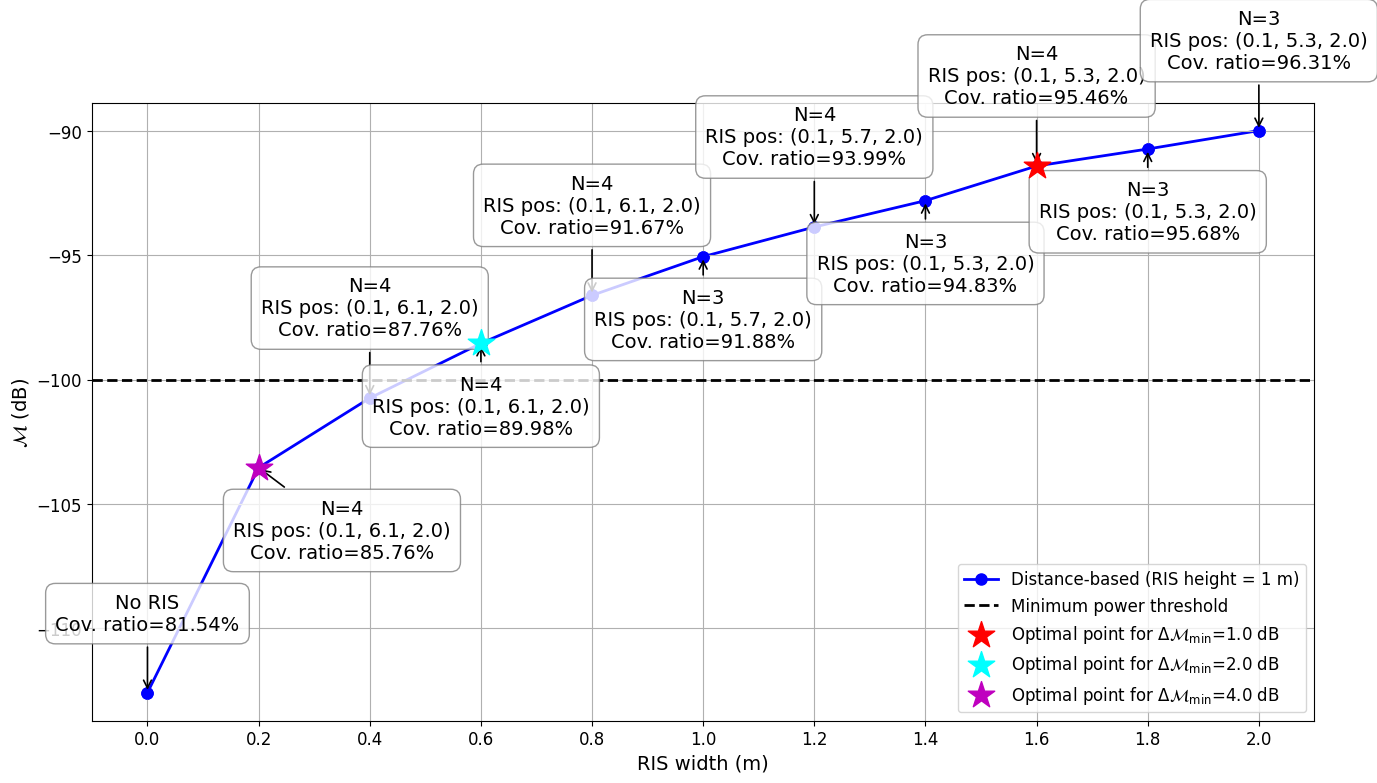

In [59]:
# Performance metric vs. RIS width figure plotting
import json
import matplotlib.pyplot as plt
from collections import defaultdict
import ast
import numpy as np

# Function to parse RIS configuration
def parse_config(config_str):
    return ast.literal_eval(config_str)

# Function to find the best configuration for each RIS width
def find_best_configs_per_width(data):
    width_groups = defaultdict(list)
    for config_str, performance in data.items():
        if config_str == "no_RIS_contribution":
            continue
        _, width, _ = parse_config(config_str)
        width_groups[width].append((config_str, performance))
    best_configs = {width: max(configs, key=lambda x: x[1]) for width, configs in width_groups.items()}
    return best_configs

# Function to find the optimal configuration for a given threshold
def find_optimal_configuration(best_configs_per_width, improvement_threshold):
    sorted_widths = sorted(best_configs_per_width.keys())
    current_config = best_configs_per_width[sorted_widths[0]]
    optimal_config = current_config
    for next_width in sorted_widths[1:]:
        next_config = best_configs_per_width[next_width]
        improvement = next_config[1] - current_config[1]
        if improvement > improvement_threshold:
            optimal_config = next_config
            current_config = next_config
        else:
            break
    return optimal_config

# Visualization function
def visualize_performance_vs_width(best_configs_per_width, thresholds, coverage_ratios, no_ris_performance=-102.95):
    widths = [0.0]
    performances = [no_ris_performance]
    annotations = ["No RIS\nCov. ratio=85%"]
    for width in sorted(best_configs_per_width.keys()):
        config_str, performance = best_configs_per_width[width]
        num_targets, _, position = parse_config(config_str)
        coverage_ratio = coverage_ratios.get(config_str, 0)
        widths.append(width)
        performances.append(performance)
        annotations.append(f"N={num_targets}\nRIS pos: ({position[0]:.1f}, {position[1]:.1f}, {position[2]:.1f})\nCov. ratio={coverage_ratio:.2f}%")
    
    plt.figure(figsize=(16, 8))
    # Plot the curve
    plt.plot(widths, performances, 'b-', linewidth=2, zorder=1)  # Curve below markers
    plt.plot(widths, performances, 'bo', markersize=8, zorder=2)  # Markers on curve

    # Annotate points
    for i, (x, y, annot) in enumerate(zip(widths, performances, annotations)):
        plt.annotate(annot, xy=(x, y), xytext=(0, 20 if i % 2 == 0 else -40),
                     textcoords='offset points', ha='center', fontsize=10,
                     bbox=dict(boxstyle='round,pad=0.5', fc='white', ec='gray', alpha=0.8),
                     arrowprops=dict(arrowstyle='->', color='black', lw=0.7))

    # Add optimal points
    colors = ['r', 'g', 'm']
    markers = ['*', '*', '*']
    for i, threshold in enumerate(thresholds):
        optimal_config = find_optimal_configuration(best_configs_per_width, threshold)
        if optimal_config:
            config_str, optimal_performance = optimal_config
            _, optimal_width, _ = parse_config(config_str)
            plt.scatter(optimal_width, optimal_performance, color=colors[i], marker=markers[i], s=180,
                        label=f"Optimal point for $\Delta \\mathcal{{M}}_{{\\text{{min}}}}$={threshold:.1f} dB", zorder=3)  # Optimal points above curve

    plt.xlabel("RIS Width (m)", fontsize=12)
    plt.ylabel("$\mathcal{M}$ (dB)", fontsize=12)
    #plt.title("Performance Metric vs RIS Width", fontsize=14)
    plt.legend(loc="lower right", fontsize=10)
    plt.grid(True)
    plt.tight_layout()
    plt.savefig("perf_metric_vs_RIS_width.png", bbox_inches="tight")
    plt.show()

# Visualization function for multiple curves
def visualize_multiple_curves(curve_data, thresholds, no_ris_performance=-112.58379364013672):
    """
    Plot multiple performance vs. RIS width curves with consolidated optimal point labels.
    
    Parameters:
    - curve_data: List of dictionaries containing 'best_configs', 'coverage_ratios', 'label', and 'color' for each curve.
    - thresholds: List of improvement thresholds for optimal points.
    - no_ris_performance: No RIS performance metric.
    """
    plt.figure(figsize=(14, 8))

    # Iterate over the curves to plot them
    markers_plots = ['o','>','<','x']
    for curve_count, curve in enumerate(curve_data):
        best_configs_per_width = curve['best_configs']
        coverage_ratios = curve['coverage_ratios']
        curve_label = curve['label']
        curve_color = curve['color']

        widths = [0.0]
        performances = [no_ris_performance]
        annotations = ["No RIS\nCov. ratio=81.54%"]
        for width in sorted(best_configs_per_width.keys()):
            config_str, performance = best_configs_per_width[width]
            num_targets, _, position = parse_config(config_str)
            coverage_ratio = coverage_ratios.get(config_str, 0)
            widths.append(width)
            performances.append(performance)
            annotations.append(
                f"N={num_targets}\nRIS pos: ({position[0]:.1f}, {position[1]:.1f}, {position[2]:.1f})\nCov. ratio={coverage_ratio:.2f}%"
            )

        # Plot the curve
        plt.plot(widths, performances, color=curve_color, linestyle='-', marker=markers_plots[curve_count], markersize=8, linewidth=2, label=curve_label, zorder=1)
        plt.plot(widths, performances, color=curve_color, marker=markers_plots[curve_count], markersize=8, linestyle='None', zorder=2)
        plt.rcParams.update({'font.size': 12})
        # Annotate points
        for i, (x, y, annot) in enumerate(zip(widths, performances, annotations)):
            if i == 1:
                plt.annotate(
                    annot,
                    xy=(x, y),
                    xytext=(60, 45 if i % 2 == 0 else -65),  # Alternate annotation placement
                    textcoords='offset points',
                    ha='center',
                    fontsize=14,
                    bbox=dict(boxstyle='round,pad=0.5', fc='white', ec='gray', alpha=0.8),
                    arrowprops=dict(arrowstyle='->', color='black', lw=1.2),
                )
            else:    
                plt.annotate(
                    annot,
                    xy=(x, y),
                    xytext=(0, 45 if i % 2 == 0 else -65),  # Alternate annotation placement
                    textcoords='offset points',
                    ha='center',
                    fontsize=14,
                    bbox=dict(boxstyle='round,pad=0.5', fc='white', ec='gray', alpha=0.8),
                    arrowprops=dict(arrowstyle='->', color='black', lw=1.2),
                )
    plt.axhline(y=-100, color='black', linestyle='--', linewidth=2, label="Minimum power threshold")
    # Add optimal points for each threshold across all curves
    colors = ['r', 'Cyan', 'm']
    markers = ['*', '*', '*']
    for i, threshold in enumerate(thresholds):
        for curve in curve_data:
            best_configs_per_width = curve['best_configs']
            optimal_config = find_optimal_configuration(best_configs_per_width, threshold)
            if optimal_config:
                config_str, optimal_performance = optimal_config
                _, optimal_width, _ = parse_config(config_str)
                plt.scatter(
                    optimal_width,
                    optimal_performance,
                    color=colors[i],
                    marker=markers[i],
                    s=400,
                    zorder=3,
                )

        # Add a single legend entry for the threshold
        plt.scatter([], [], color=colors[i], marker=markers[i], s=400, 
                    label=f"Optimal point for $\Delta \\mathcal{{M}}_{{\\text{{min}}}}$={threshold:.1f} dB")

    plt.xlabel("RIS width (m)", fontsize=14)
    plt.ylabel("$\mathcal{M}$ (dB)", fontsize=14)
    #plt.title("Performance Metric vs RIS Width", fontsize=14)
    plt.legend(loc="lower right", fontsize=12)
    plt.grid(True)
    plt.tight_layout()
    x_ticks = np.arange(0, 2.2, 0.2)  # 2.2 to include 2.0 in case of floating point precision issues
    plt.xticks(x_ticks)
    plt.savefig("multiple_curves_perf_metric_vs_RIS_width.png", bbox_inches="tight")
    plt.show()

def define_curve(metrics_file, coverage_file, label, color):
    with open(metrics_file, 'r') as f1, open(coverage_file, 'r') as f2:
        metrics_data = json.load(f1)
        coverage_data = json.load(f2)
    best_configs = find_best_configs_per_width(metrics_data)
    return {'best_configs': best_configs, 'coverage_ratios': coverage_data, 'label': label, 'color': color}
if __name__ == "__main__":
    # Define multiple curves
    curves = [
        define_curve("Paper-OJAP\Data results\Distance-based\metrics_RIS_height_1.0_-100dB_Distance-based.json", "Paper-OJAP\Data results\Distance-based\metrics_coverage_ratio_RIS_height_1.0_-100dB_Distance-based.json", "Distance-based (RIS height = 1 m)", 'blue'),
        #define_curve("Paper-OJAP\Data results\Distance-based\metrics_RIS_height_0.5_-100dB_Distance-based.json", "Paper-OJAP\Data results\Distance-based\metrics_coverage_ratio_RIS_height_0.5_-100dB_Distance-based.json", "Distance-based (RIS height = 0.5 m)", 'orange'),
        #define_curve("Paper-OJAP\Data results\Gradient-based\metrics_RIS_height_1.0_-100dB_Gradient-based.json", "Paper-OJAP\Data results\Gradient-based\metrics_coverage_ratio_RIS_height_1.0_-100dB_Gradient-based.json", "Gradient-based (RIS height = 1 m)", 'green'),
        #define_curve("Paper-OJAP\Data results\Gradient-based\metrics_RIS_height_0.5_-100dB_Gradient-based.json", "Paper-OJAP\Data results\Gradient-based\metrics_coverage_ratio_RIS_height_0.5_-100dB_Gradient-based.json", "Gradient-based (RIS height = 0.5 m)", 'black')
    ]
    
    # Threshold values
    thresholds = [1, 2, 4]  # Example thresholds (in dB)

    # Visualize multiple curves
    visualize_multiple_curves(curves, thresholds)